<a href="https://colab.research.google.com/github/PMartey/KaggleX-Project/blob/main/Preparing_Stock_trade_and_Ins_QnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Since the finance data set used in training the first gemma model
  answered prompts like on the slack app this really isn't factually accurate.  
  For instance the model couldnot explain what a checking account is, also so it couldn't differentiate between a checking and savings account.  
  The fine tuned model also had a low rouge and bleu score

#Import Necessary libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Prep Insuarance Dataset [Link to source](https://huggingface.co/datasets/sujra/insurance_llama2_145)

In [ ]:
ins_qa = pd.read_parquet("hf://datasets/sujra/insurance_llama2_145/data/train-00000-of-00001.parquet")
ins_qa.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text
0,"<s>[INST] Understanding fund performance, NAV ..."
1,<s>[INST] What are the different types of life...
2,"<s>[INST] Define an """"Organisation-wide Policy..."
3,<s>[INST] Give some information about what inf...
4,<s>[INST] How does insurance underwriting work...


In [ ]:
# cleaning up the text format
# Removing <s> and </s> tags
ins_qa['text'] = ins_qa['text'].str.replace('<s>', '').str.replace('</s>', '')  # Replace 'text_column' with your actual column name

import re


# Function to extract question and answer
def split_question_answer(text):
    # Extract the question between [INST] and [/INST]
    question_match = re.search(r'\[INST\](.*?)\[/INST\]', text)
    # Extract the answer by removing the [INST]...[/INST] part
    answer = re.sub(r'\[INST\].*?\[/INST\]', '', text).strip()

    if question_match:
        question = question_match.group(1).strip()  # Extract and clean question
    else:
        question = None  # No question found

    return question, answer  # Return question and answer

# Apply the function to split the text into 'Question' and 'Answer' columns
ins_qa[['question', 'answer']] = ins_qa['text'].apply(lambda x: pd.Series(split_question_answer(x)))

In [ ]:
#Checking my data set
ins_qa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      140 non-null    object
 1   question  140 non-null    object
 2   answer    140 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB


In [ ]:
# Dropping the text column to include just q and a
ins_qna = ins_qa.drop(columns=['text'], inplace=True)

## Prep Stock trading QnA [link to source](https://huggingface.co/datasets/yymYYM/stock_trading_QA)

In [ ]:
import pandas as pd

st_qna = pd.read_csv("hf://datasets/yymYYM/stock_trading_QA/stock_trading_qa_pairs_processed.csv")
st_qna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7165 non-null   int64 
 1   question    7165 non-null   object
 2   answer      7165 non-null   object
dtypes: int64(1), object(2)
memory usage: 168.1+ KB


In [ ]:
st_qna.columns
st_qna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  7165 non-null   object
 1   answer    7165 non-null   object
dtypes: object(2)
memory usage: 112.1+ KB


In [ ]:
# Dropping Unnamed:0 column to include just q and a
#st_qna1 = st_qna.drop(columns=['Unnamed: 0'], inplace= True)


In [ ]:
st_qna1 = st_qna.sample(n=145, random_state=42)

## Merge and Explore data set


In [ ]:
from typing_extensions import final
final_df = pd.concat([ins_qa, st_qna1], axis=0)

# since i merge 2 data sets together I have to mix them before sampling 250
final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  285 non-null    object
 1   answer    285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


In [ ]:
# there are no null values
qna_df = final_df

def clean_text(text):
    #text = text.str.lower()  # Lowercase using .str.lower() for Series
    text = text.str.replace(r'\s+', ' ', regex=True)  # Remove extra whitespace
    text = text.str.replace(r'<.*?>', '', regex=True)  # Remove HTML tags if present
    # Remove special characters except alphanumeric and common punctuation for questions/answers
    text = text.str.replace(r'[^A-Za-z0-9\s\.,!?[\]""]', '', regex=True)
    return text


# Apply cleaning
qna_df['question'] = clean_text(qna_df['question'])
qna_df['answer'] = clean_text(qna_df['answer'])

print(qna_df)

                                              question  \
0    What is the impact of inflation on stock tradi...   
1    What role does market breadth play in quantita...   
2    Summarize the key points to consider when rece...   
3    What are technical indicators commonly used in...   
4    How can one purchase LICs Cancer Cover Plan on...   
..                                                 ...   
280  How do the tax benefits of LIC policies compar...   
281  Highlight the features and flexibility of HDFC...   
282  What are the key benefits of LIC policies for ...   
283  Can you explain the difference between life in...   
284  Do independent agencies award higher financial...   

                                                answer  
0    Inflation can impact stock trading models by i...  
1    Market breadth refers to the number of securit...  
2    Personal Details Accuracy Verify the accuracy ...  
3    Common technical indicators include moving ave...  
4    The plan can 

In [ ]:
# Select rows not in english other language
qna_df['question'].apply(lambda text: bool(re.search(r'[^\x00-\x7F]+', text)))

,question
0,False
1,False
2,False
3,False
4,False
...,...
280,False
281,False
282,False
283,False


In [ ]:
# Check for duplicates
print(f"Duplicate question-answer pairs: {qna_df.duplicated(['question', 'answer']).sum()}")
qna_df1 = qna_df.drop_duplicates(subset=['question', 'answer'])



Duplicate question-answer pairs: 2


<ipython-input-16-9435b71212ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qna_df1['question_len'] = qna_df1['question'].apply(len)
<ipython-input-16-9435b71212ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qna_df1['answer_len'] = qna_df1['answer'].apply(len)


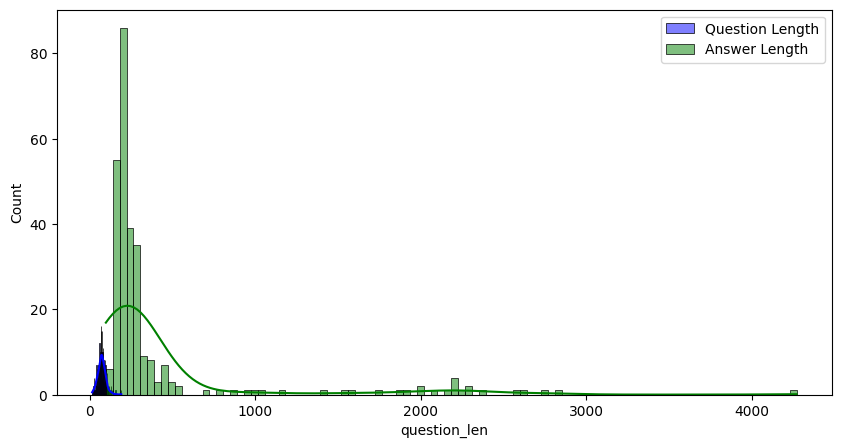

In [ ]:
# Visualize text length distributions
qna_df1['question_len'] = qna_df1['question'].apply(len)
qna_df1['answer_len'] = qna_df1['answer'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(qna_df1['question_len'], bins=100, kde=True, color='blue', label='Question Length')
sns.histplot(qna_df1['answer_len'], bins=100, kde=True, color='green', label='Answer Length')
plt.legend()
plt.show()

In [ ]:
qna_df1.drop(columns=['question_len', 'answer_len'], inplace=True)

<ipython-input-17-a26fbbb4beb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qna_df1.drop(columns=['question_len', 'answer_len'], inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(qna_df1, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.to_csv('train1_data.csv', index=False)
val_df.to_csv('val1_data.csv', index=False)
test_df.to_csv('test1_data.csv', index=False)